# Conflow

A model workflow for Conflow, a program to calculate flow properties of magma-gas mixtures through eruptive conduits during steady explosive volcanic eruptions. This can be used with other models to maximize preduction accuracy.

In [1]:
import pandas as pd
import subprocess
from subprocess import PIPE, STDOUT, run, Popen
import os
import matplotlib.pyplot as plt

### Below, please enter all the required values.

Pay close attention to the oxide percentages, and make sure they add up to 100, otherwise Conflow will proportionally scale all values. Assume SI units wherever applicable.

Below is a short note on the iteration parameter you choose.

NOTES ON INPUT PARAMETERS:

iteration #=2 if the velocity is to be adjusted automatically to reachsonic velocities at the exit (valid only if icalc= 10 ), or 1 if no adjustment is desired.
<br>vesiculation p.= 2 if gas exsolution is to stop after fragmentationm 1 if not
<br>1=vfgas = constant if no dp/dt calculation using Toramaru formulations is desired, please write 0 
<br>2=mixture viscosity\*strain rate > 25 GPa
<br>3=mixture viscosity\*strain rate > 0.01*elastic modulus of celluar solid
<br>4=fragmentation at eta \* dvdz \* stress concentration around bubble wall > 250 MPa

In [2]:
#specify conduit diameter (diam) or pressure gradient (pgrd)
diam_pgrd = 'diam'

#initial, final pressure
ipa, fpa = 150, .1

#iteration parameter, see above for details
iter = 2

#initial velocity
init_v = 1

#initial temperature, type of temp (const or variable)
init_temp, var_const_t = 1100, 2

#specific heat of crystals
sphoc = 1702.5

#percent of H2O in the mixture
water_percent = 1.85

#vesicularity
vesi_param = 1

#initial and final depth
init_depth, final_depth = 6000.0, 0.0

#diameter of simulation cylinder
conduit_diam_bottom, conduit_diam_top = 20.00, 20.00

#acceleration due to gravity (to allow for extra-terrestrial sim)
gravity = 9.81

#All

#weight percent of SiO2
siO2_percent = 49.5

al2Oe_percent = 18.7

fe2O3_percent = 7.90

feO_percent = 3.1

mnO_percent = .2

mgO_percent = 2.8

caO_percent = 9.4

tiO2_percent = 1.95

na2O_percent = 4.2

k2O_percent = 1.75

p2O5 = .50

f2O1 = 0.0

crystal_percent_1, crystal_density_1, crystal_ar_1 = 28, 2630, 5
crystal_percent_2, crystal_density_2, crystal_ar_2 = 0, 3190, 3
crystal_percent_3, crystal_density_3, crystal_ar_3 = 0, 3190, 1.76

bubble_number = 2.8e15

surface_tension = .035

diff_vol = 2e-12

fraction_fragment = .75

frag_criterion = 1

### Run the next two cells to correctly format the input file.

No alterations should be made.

In [3]:
notes = '''
NOTES ON INPUT PARAMETERS:
*iteration #=2 if the velocity is to be adjusted automatically to reach
            sonic velocities at the exit (valid only if icalc= 10 ), or
         1 if no adjustment is desired.
**vesiculation p.= 2 if gas exsolution is to stop after fragmentation
               1 if not
***1=vfgas = constant ****if no dp/dt calculation using Toramaru formulations is desired, please write 0 
2=mixture viscosity*strain rate > 25 GPa
3=mixture viscosity*strain rate > 0.01*elastic modulus of celluar solid
4=fragmentation at eta * dvdz * stress concentration around bubble wall > 250 MPa
'''

In [4]:
params = f'''INPUT PARAMETERS:        PARAMETER EXPLANATIONS:
data.out                  name of output file
{diam_pgrd}                          specify conduit diameter (diam) or pressure gradient (pgrd)
{ipa}, {fpa}                   initial, final pressure (MPa)
 {iter}                            iteration number*
{init_v}                          initial velocity (m/s)
{init_temp}     {var_const_t}                    initial temperature (C), itemp (1=const T, 2=variable T)
{sphoc}                        sp. heat of crystals (J/kg K)
{water_percent}                          h2o content (wt%)
 {vesi_param}                            vesiculation parameter**
{init_depth}, {final_depth}                   initial, final depth (m)
{conduit_diam_bottom}, {conduit_diam_top}                  conduit diameter (m) at bottom, top
{gravity}                          gravitational acceleration (m/s2)
{siO2_percent}                         Weight % SiO2 (anhydrous)
{al2Oe_percent}                         Weight % Al2O3 (anhydrous)
{fe2O3_percent}                          Weight % Fe2O3 (anhydrous)
{feO_percent}                          Weight % FeO (anhydrous)
{mnO_percent}                          Weight % MnO (anhydrous)
{mgO_percent}                          Weight % MgO (anhydrous)
{caO_percent}                          Weight % CaO (anhydrous)
{tiO2_percent}                          Weight % TiO2 (anhydrous)
{na2O_percent}                          Weight % Na2O (anhydrous)
{k2O_percent}                          Weight % K2O (anhydrous)
{p2O5}                          Weight % P2O5 (anhydrous)
{f2O1}                          Weight % F2O-1 (anhydrous)
{crystal_percent_1}, {crystal_density_1}, {crystal_ar_1}                   (plg)   PHASE 1: volume % crystals, crystal density (kg/m3), ar
{crystal_percent_2}, {crystal_density_2}, {crystal_ar_2}       	      (cpx)    PHASE 2: volume % crystals, crystal density (kg/m3), ar
{crystal_percent_3}, {crystal_density_3}, {crystal_ar_3}	              (ox)    PHASE 3: volume % crystals, crystal density (kg/m3), ar
{bubble_number}  	              bubble number density for smallest vesicle sizes (cm-3)****
{surface_tension}			      surface tension (N/m)
{diff_vol}			      diffusivity volatile D (m2/s)
{fraction_fragment}                          volume fraction gas at which fragmentation occurs
 {frag_criterion}                            fragmentation criterion (1=vfgas, 2=strain-rate)
'''

### Select Output Parameters

Conflow is configured to only output 7 at a time. Below is the complete list of possible outputs. Please follow the instructions described.

In the following cell, enter a number indicating the column where this variable will be written in the output file. You must select 7 variables. For best uses, we recommend 6 (time) along with 6 other values.

1. x-sectional area (m2)
2. Mach number
3. pressure (MPa)
4. log Reynolds number
5. mixture density
6. time (s) since entering conduit
7. velocity (m/s)
8. volume fraction gas
9. log viscosity (Pa s)
10. z (depth, meters)
11. d(x-s area)/dz, meters
12. log pressure (MPa)
13. dpdz (pressure gradient, Pa/m)
14. log dz (vert. step size, m)
15. f (friction factor)
16. gamma (Cp/Cv for gas phase)
17. mf (mass fraction exsolved gas)
18. mm (mass fraction magma)
19. r (Universal Gas const. * n)
20. rhof (gas density)
21. sv (sonic velocity (m/s)
22. temperature (C)
23. enthalpy of mixture (kJ/kg)
24. cp (sp. heat) of gas (kJ/kg C)
25. conduit radius(m)
26. dissolved h2o (wt%)
27. cp (sp. heat) of melt (kJ/kg C)

In [1]:
choices = [6,2,3,8,5,22,7]

### The model is ready to run! Please run all following cells to the end.

In [2]:
outputs =  '''
Output Parameters:
List of variables to be written out. Enter a number in the
first column indicating the column # where this variable will be written
in the output file.  You can write out up to seven variables.'''
variables = '''
         x-sectional area (m2)
         Mach number
         pressure (MPa)
         log Reynolds number
         mixture density
         time (s) since entering conduit
         velocity (m/s)
         volume fraction gas
         log viscosity (Pa s)
         z (depth, meters)
         d(x-s area)/dz, meters
         log pressure (MPa)
         dpdz (pressure gradient, Pa/m)
         log dz (vert. step size, m)
         f (friction factor)
         gamma (Cp/Cv for gas phase)
         mf (mass fraction exsolved gas)
         mm (mass fraction magma)
         r (Universal Gas const. * n)
         rhof (gas density)
         sv (sonic velocity (m/s)
         temperature (C)
         enthalpy of mixture (kJ/kg)
         cp (sp. heat) of gas (kJ/kg C)
         conduit radius(m)
         dissolved h2o (wt%)
         cp (sp. heat) of melt (kJ/kg C)'''

In [3]:
altered = ""
for num, line in enumerate(variables.splitlines()):
    if num in choices:
        altered = altered + str(choices.index(num)+1)+line+"\n"
    else:
        altered = altered + line+"\n"

In [8]:
all_headers = ["area","mach","p (MPa)","log Re","density", "time (s)", "vel (m/s)", "vfgas", "log visc", "z (m)", "dadz","log(p)","dpdz","dz (m)", "f", "gamma", "mgas/mtot", "mmag/mtot", "R (J/m K)", "gas dens", "sonic vel", "temp(c)", "h (kJ/kg", "cp", "radius", "dh2o(wt%)", "cm (J/kgK)"]
headers = [all_headers[i-1] for i in choices]

In [9]:
with open("conin.txt",'w') as f:
    f.write(params + notes + outputs+ altered)
yes = b"""y
y"""

In [10]:
p = subprocess.run("./conflow", shell=True, input=yes)

### The model has run! Please run the following cells for the workflow to format and plot your results.

In [11]:
df = pd.read_csv("data.out",skiprows=179,sep='\s+',usecols=range(1,8), names=headers)
df.to_csv("Conflow.csv")

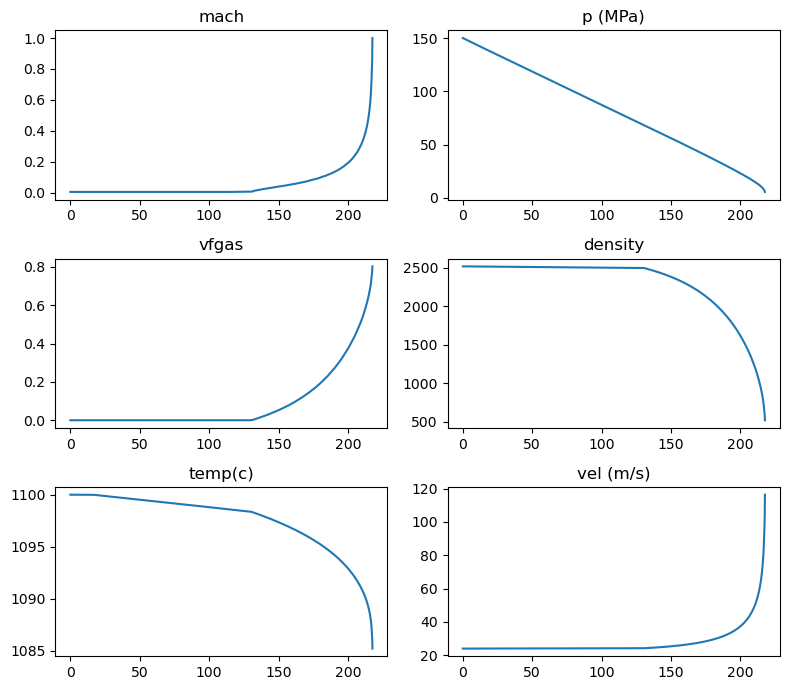

In [12]:
ds = pd.read_csv("Conflow.csv")
if 6 in choices:
    fig, axs = plt.subplots(3, 2, figsize=(8,7))
    hd = headers
    hd.remove("time (s)")
    for header, ax in zip(hd, axs.ravel()):
            ax.plot(df["time (s)"],df[header])
            ax.set_title(header)
            plt.tight_layout()
else:
    fig, axs = plt.subplots(4, 2, figsize=(8,7))
    for header, ax in zip(headers, axs.ravel()):
        df[header].plot(ax=ax)
        ax.set_title(header)
        plt.tight_layout()